In [1]:
# importing required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import cross_validate, KFold
from surprise import accuracy

plt.style.use("seaborn-v0_8")


In [2]:
# getting data
data_path = "../data/ratings_small.csv"
df = pd.read_csv(data_path)[["userId", "movieId", "rating"]]
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df, reader)

# preview data
df.head()


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [3]:
print("Running PMF SVD, unbiased")

# PMF SVD, unbiased
algo_pmf = SVD(biased=False, n_factors=50, n_epochs=20, random_state=42)
cv_pmf = cross_validate(algo_pmf, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# compute average RMSE and MAE
pmf_rmse = np.mean(cv_pmf["test_rmse"])
pmf_mae  = np.mean(cv_pmf["test_mae"])

# print results
pmf_rmse, pmf_mae


Running PMF SVD, unbiased


(0.9896148986691312, 0.7596894921178448)

In [4]:
print("Running Item-Based CF cosine")

# Item-Based CF cosine
algo_item = KNNBasic(sim_options={'user_based': False, 'name':'cosine'}, random_state=42)
cv_item = cross_validate(algo_item, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# compute average RMSE and MAE
item_rmse = np.mean(cv_item["test_rmse"])
item_mae  = np.mean(cv_item["test_mae"])

# print results
item_rmse, item_mae

Running Item-Based CF cosine
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


(0.9947243702112022, 0.7742142618638359)

In [5]:
print("Running User-Based CF (cosine)...")

# User-Based CF cosine
algo_user = KNNBasic(sim_options={'user_based': True, 'name':'cosine'}, random_state=42)
cv_user = cross_validate(algo_user, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# compute average RMSE and MAE
user_rmse = np.mean(cv_user["test_rmse"])
user_mae  = np.mean(cv_user["test_mae"])

# print results
user_rmse, user_mae


Running User-Based CF (cosine)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


(0.9946273201659344, 0.7679273893388684)

In [6]:
# summarize results 
baseline_results = pd.DataFrame({
    "Model": ["PMF", "UserCF", "ItemCF"],
    "RMSE": [pmf_rmse, user_rmse, item_rmse],
    "MAE":  [pmf_mae,  user_mae,  item_mae]
}).round(4)

# print results
baseline_results

,Model,RMSE,MAE
0,PMF,0.9896,0.7597
1,UserCF,0.9946,0.7679
2,ItemCF,0.9947,0.7742


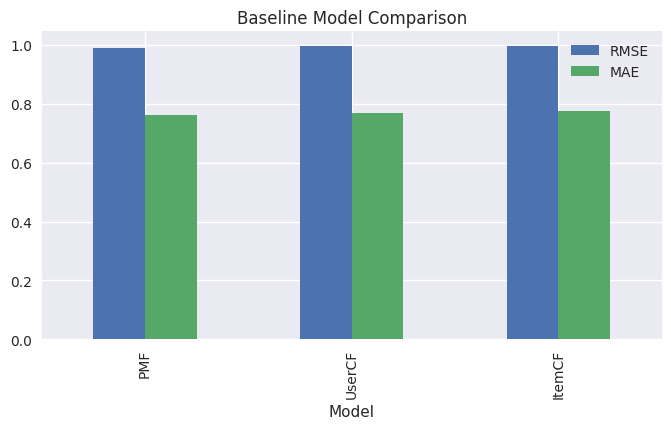

In [7]:
# plot results
baseline_results.plot(x="Model", y=["RMSE","MAE"], kind="bar", figsize=(8,4), title="Baseline Model Comparison")
plt.show()

In [8]:

# experimenting with different similarity metrics
similarities = ["cosine", "msd", "pearson"]

# store results
records = []

# loop over similarity metrics
for sim in similarities:
    
    # UserCF
    algo_u = KNNBasic(sim_options={'user_based': True, 'name': sim}, random_state=42)
    cv_u = cross_validate(algo_u, data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    records.append(["UserCF", sim, np.mean(cv_u["test_rmse"]), np.mean(cv_u["test_mae"])])
    
    # ItemCF
    algo_i = KNNBasic(sim_options={'user_based': False, 'name': sim}, random_state=42)
    cv_i = cross_validate(algo_i, data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    records.append(["ItemCF", sim, np.mean(cv_i["test_rmse"]), np.mean(cv_i["test_mae"])])

# create dataframe
sim_df = pd.DataFrame(records, columns=["Model", "Similarity", "RMSE", "MAE"]).round(4)
sim_df


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

,Model,Similarity,RMSE,MAE
0,UserCF,cosine,0.9945,0.7680
1,ItemCF,cosine,0.9942,0.7746
2,UserCF,msd,0.9696,0.7454
3,ItemCF,msd,0.9336,0.7201
4,UserCF,pearson,0.9992,0.7729
5,ItemCF,pearson,0.9890,0.7677


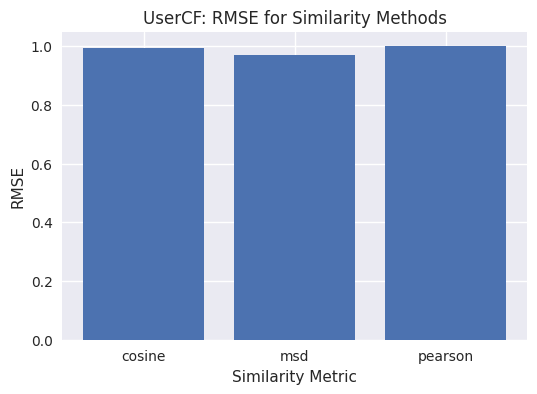

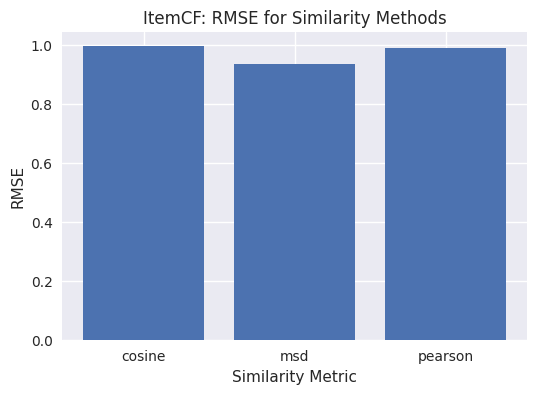

In [9]:
# plot results
for model in ["UserCF", "ItemCF"]:
    sub = sim_df[sim_df.Model == model]
    plt.figure(figsize=(6,4))
    plt.bar(sub["Similarity"], sub["RMSE"])
    plt.title(f"{model}: RMSE for Similarity Methods")
    plt.xlabel("Similarity Metric")
    plt.ylabel("RMSE")
    plt.show()


In [10]:
# tuning K for User-Based CF
k_values = [5, 10, 20, 30, 40, 60, 80]

# store results
results_user = []

# cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# loop over K values
for k in k_values:
    rmses = []
    
    # cross-validation
    for trainset, testset in kf.split(data):
        algo = KNNBasic(k=k, min_k=2, sim_options={'user_based': True, 'name':'cosine'}, random_state=42)
        algo.fit(trainset)
        
        preds = algo.test(testset)
        rmses.append(accuracy.rmse(preds, verbose=False))
        
    # store average RMSE for this K
    results_user.append([k, np.mean(rmses)])

# create dataframe
user_k_df = pd.DataFrame(results_user, columns=["K", "RMSE"]).round(4)
user_k_df


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

,K,RMSE
0,5,1.0378
1,10,1.0028
2,20,0.9902
3,30,0.9875
4,40,0.9867
5,60,0.9869
6,80,0.9873


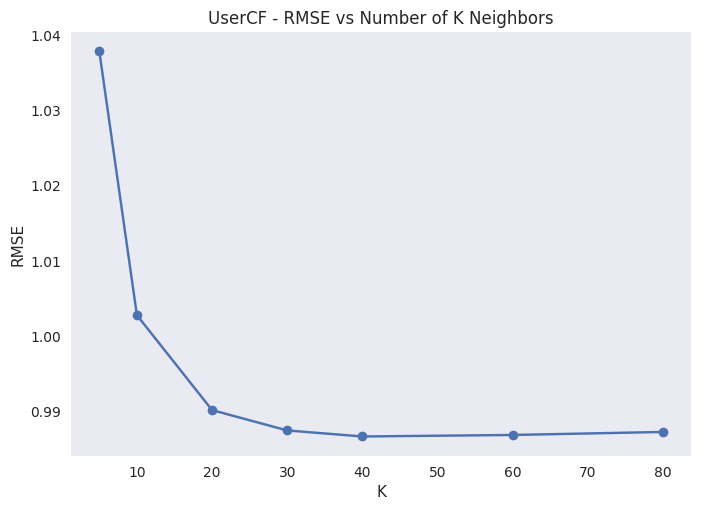

In [11]:
# plot results
plt.plot(user_k_df["K"], user_k_df["RMSE"], marker='o')
plt.title("UserCF - RMSE vs Number of K Neighbors")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid()
plt.show()


In [12]:
# find best K
best_user = user_k_df.loc[user_k_df["RMSE"].idxmin()]
best_user


K       40.0000
RMSE     0.9867
Name: 4, dtype: float64

In [13]:
# tuning K for Item-Based CF
results_item = []

# cross-validation setup
for k in k_values:
    rmses = []
    
    for trainset, testset in kf.split(data):
        algo = KNNBasic(k=k, min_k=2, sim_options={'user_based': False, 'name':'cosine'}, random_state=42)
        algo.fit(trainset)
        
        preds = algo.test(testset)
        rmses.append(accuracy.rmse(preds, verbose=False))
        
    results_item.append([k, np.mean(rmses)])

# create dataframe
item_k_df = pd.DataFrame(results_item, columns=["K", "RMSE"]).round(4)
item_k_df


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

,K,RMSE
0,5,1.1009
1,10,1.0507
2,20,1.0171
3,30,1.0031
4,40,0.9950
5,60,0.9857
6,80,0.9807


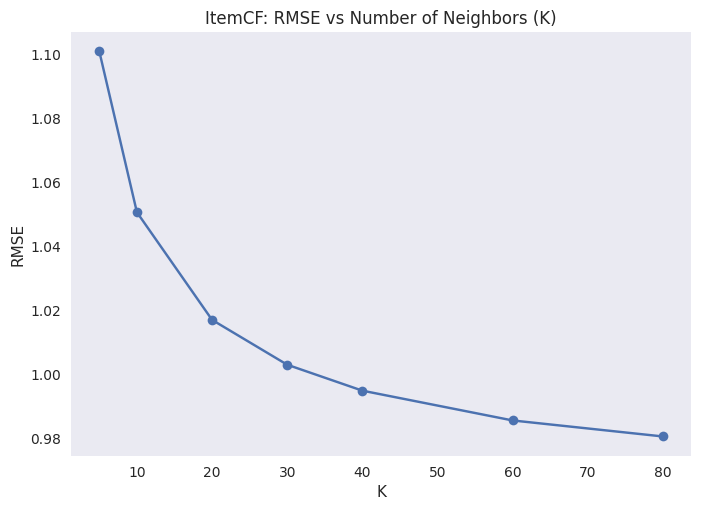

In [14]:
# plot results
plt.plot(item_k_df["K"], item_k_df["RMSE"], marker='o')
plt.title("ItemCF: RMSE vs Number of Neighbors (K)")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid()
plt.show()

In [15]:
# find best K
best_item = item_k_df.loc[item_k_df["RMSE"].idxmin()]
best_item

K       80.0000
RMSE     0.9807
Name: 6, dtype: float64

In [ ]:
# save results
df.to_csv("../results/recsys/baseline_models.csv", index=False)
sim_df.to_csv("../results/recsys/similarity_metrics.csv", index=False)
user_k_df.to_csv("../results/recsys/k_tuning_usercf.csv", index=False)
item_k_df.to_csv("../results/recsys/k_tuning_itemcf.csv", index=False)